# Detecting Argumentative Discourse Units with Linguistic Alignment

This notebook reproduces the results in our [paper](add_link_here).

Note:
- The data provided is not text but rather LIWC frequencies for anonymyzed comments, and our annotations
- We do not provide anything that would infringe copyright

In [53]:
import pystan

from align import logreg, stan, util

## Load the Data

In [24]:
data = util.load_json('data')
author_baselines = util.load_json('author_baselines')
author_means = util.load_json('author_means')
illocution_dict = util.load_json('illocution_dict')
category_dict = util.load_json('category_dict')

## Alignment over Illocutions

We first run the stan model to get the posterior distributions.

In [27]:
model_data = stan.get_model_data(
    data, author_baselines, author_means, illocution_dict, 
    category_dict)

In [31]:
model = pystan.StanModel(file='align/alignment_illocution.stan',
                         model_name='alignment_illocution')

INFO:pystan:COMPILING THE C++ CODE FOR MODEL alignment_illocution_0be51d5572153ad085ca803268f1494d NOW.


In [32]:
n_iters = 1000
warmup = 500
chains = 3
thin = 1
seed = 42
verbose = True
pars = ['eta_illocution_align', 'eta_category_align']

In [33]:
fit = model.sampling(
    data=model_data, iter=n_iters, warmup=warmup, chains=chains, 
    thin=thin, seed=seed, verbose=verbose, pars=pars)

In [34]:
pystan.check_hmc_diagnostics(fit)

{'n_eff': True,
 'Rhat': True,
 'divergence': True,
 'treedepth': True,
 'energy': True}

In [41]:
posteriors = stan.get_posterior_samples(fit, illocution_dict)

Plotting the distributions, as per our paper:

<Figure size 432x1152 with 0 Axes>

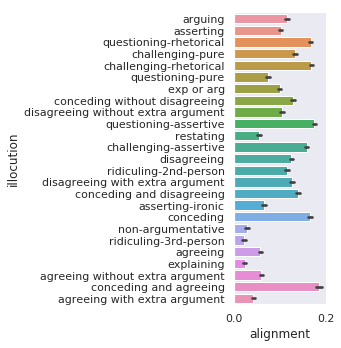

In [42]:
stan.plot_dists(posteriors)

Pairwise significance tests for difference of means. We round the p-values to two decimal places. We can see from the matrix displayed that differences are mostly significant with a handful of high p-values.

In [45]:
stan.pairwise_t(posteriors)

array([[0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
        0.  , 0.  , 0.81, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
        0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.51, 0.  , 0.33, 0.  , 0.  ,
        0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
        0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  , 0.52, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
        0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.63, 0.  , 0.  , 0.  , 0.  ,
        0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.18, 0.  , 0.  , 0.  ,
        0.  , 0.01, 0.  , 0.03, 0.02, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
        0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.52, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.02, 0.  ,
        0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.26, 0.  , 0.  , 0.  , 0.  ,
        0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
        0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0

The comparison of pure and assertive questioning, our motivating example:

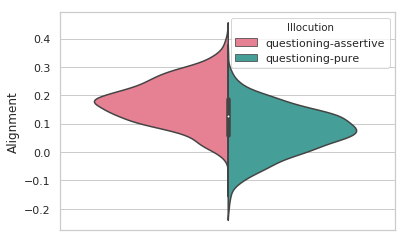

In [50]:
stan.compare_dists(
    posteriors, 'questioning-assertive', 'questioning-pure')

## Detecting Argumentative Discourse Acts

Logistic regression on each discourse act in each comment.

Note:
- Here we just supply the already bagged vectors as data

In [55]:
x_glove = util.load_npy('x_glove')
y = logreg.get_y(data, illocution_dict)

### GloVe Baseline

In [57]:
n_test = 200
x_glove_train = x_glove[0:-n_test, :]
y_train = y[0:-n_test]
x_glove_test = x_glove[-n_test:, :]
y_test = y[-n_test:]

In [59]:
glove_results = logreg.evaluate_all(
    x_glove_train, y_train, x_glove_test, y_test,
    illocution_dict)

100%|██████████| 25/25 [11:16<00:00, 28.43s/it]


### GloVe + Alignment Scores

In [60]:
x_align = logreg.get_x_align(
    data, category_dict, author_baselines, author_means)
x_glove_align = np.concatenate([x_glove, x_align], axis=1)
x_glove_align_train = x_glove_align[0:-n_test, :]
x_glove_align_test = x_glove_align[-n_test:, :]

100%|██████████| 800/800 [00:00<00:00, 10934.80it/s]


In [61]:
glove_align_results = logreg.evaluate_all(
    x_glove_align_train, y_train, x_glove_align_test, y_test,
    illocution_dict)

100%|██████████| 25/25 [27:34<00:00, 65.06s/it] 


### Comparing Results

In [62]:
logreg.compare_results(glove_results, glove_align_results)

0.684	0.684	0.000	arguing
0.560	0.640	0.081	asserting
0.497	0.497	0.000	questioning-rhetorical
0.497	0.497	0.000	challenging-pure
0.500	0.500	0.000	questioning-pure
0.497	0.495	-0.003	disagreeing without extra argument
0.495	0.497	0.003	questioning-assertive
0.497	0.490	-0.008	challenging-assertive
0.637	0.650	0.013	disagreeing
0.595	0.628	0.034	disagreeing with extra argument
0.495	0.487	-0.008	conceding and disagreeing
0.492	0.535	0.043	conceding
0.550	0.630	0.080	non-argumentative
0.500	0.497	-0.003	agreeing
0.500	0.500	0.000	agreeing without extra argument
0.497	0.497	0.000	agreeing with extra argument


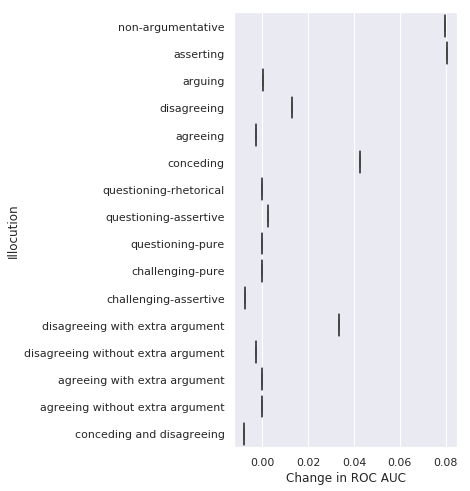

In [63]:
logreg.plot_comparison(glove_results, glove_align_results)